# **4x4 Sudoku with Grover's Search**



In [ ]:
%%capture
!pip install qiskit
!pip install pylatexenc

In [ ]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [ ]:
# output is flipped if a is not b
def XOR(qc, a, b, output):
  qc.cx(a, output)
  qc.cx(b, output)

#sudoku oracle
def sudoku_oracle(qc, clause_list, clasue_qubits, output_qubit):
  # Use XOR to check each clause
  for i, clause in enumerate(clause_list):
    XOR(qc, clause[0], clause[1], clause_qubits[i])
  # If all clauses are satisfied, flip output qubit
  qc.mct(clause_qubits, output_qubit)
  #Uncomputation: revert clause qubits to |0000> state
  for i, clause in enumerate(clause_list):
    XOR(qc, clause[0], clause[1], clause_qubits[i]) 

#set up general diffuser circuit
def diffuser(nqubits):
  qc = QuantumCircuit(nqubits)
  #add h and x gates
  for qubit in range(nqubits):
    qc.h(qubit); qc.x(qubit)
  #Do multi-controlled-Z gate, using an MCT and using Z = HXH
  qc.h(nqubits-1)
  qc.mct(list(range(nqubits-1)), nqubits-1)
  qc.h(nqubits-1)
  #apply end h and x gates
  for qubit in range(nqubits):
    qc.h(qubit); qc.x(qubit)  
  #We will return the diffusre as a gate
  U_s = qc.to_gate()
  U_s.name = "U$_s$"
  return U_s

In [ ]:
#INIT
# encodes the qubits, representative of each square in sudoku, 
# that cannot have the same value (i.e. [0,1] means qubit_0 =/= qubit_1)
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v') #variable bits
clause_qubits = QuantumRegister(4, name='c') #bits to store clause relations
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
#create circuit
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

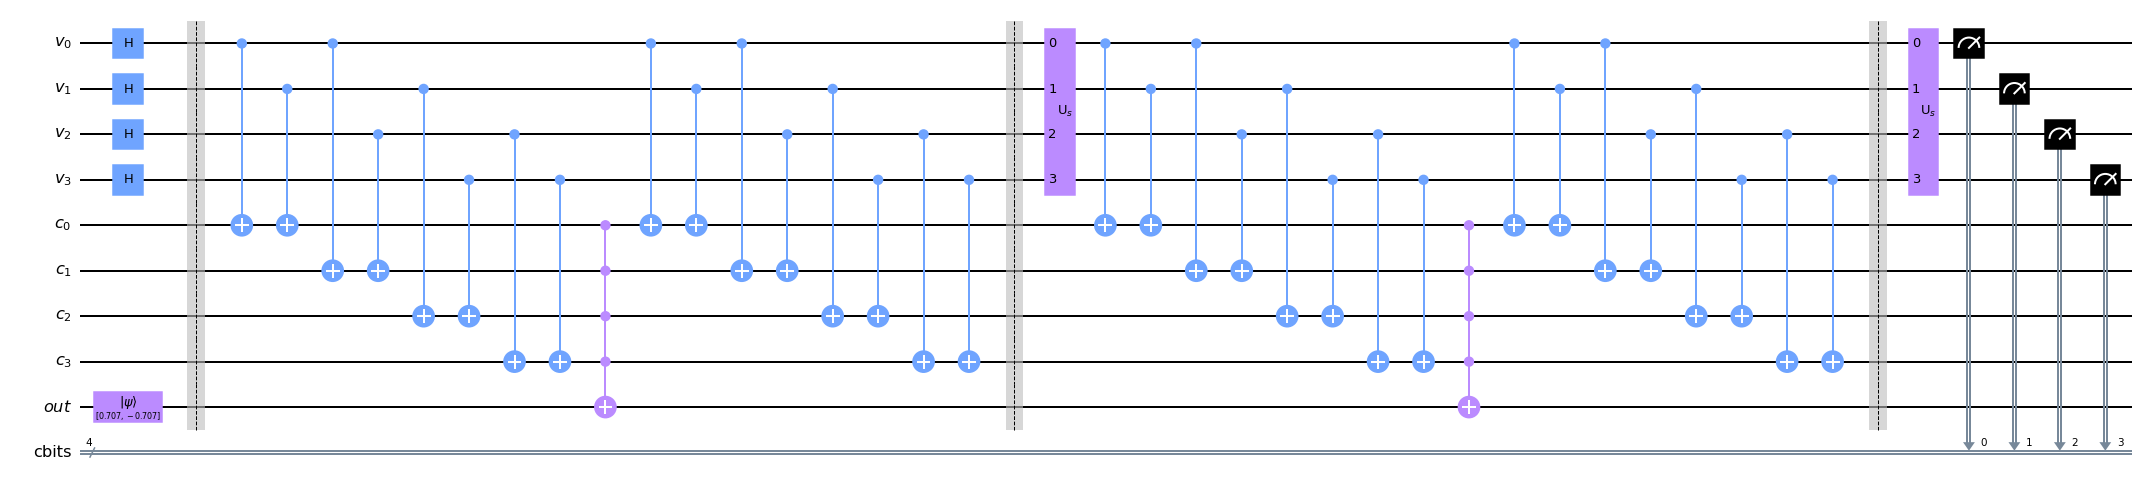

In [ ]:
iterations=2

# Initialize 'out' as |-> to enable phase kickback
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

#Put variable states into a superposition of all sudoku combinations
qc.h(var_qubits)
qc.barrier()

for i in range(iterations):
  sudoku_oracle(qc, clause_list, clause_qubits, output_qubit) #oracle
  qc.barrier() 
  qc.append(diffuser(4), [0,1,2,3])

#Measure variable qubits
qc.measure(var_qubits, cbits)
qc.draw(output='mpl', fold=-1)


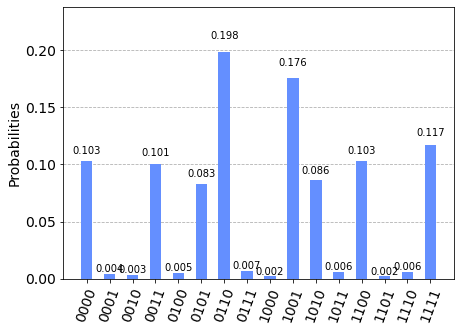

In [ ]:
simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, simulator)
qobj = assemble(transpiled_qc)
result = simulator.run(qobj).result()
plot_histogram(result.get_counts())